# scEGOT's Shilhouette Score

# Input & Preprocessings

In [1]:
out_dir = "output"
target_sum = 1e5
RANDOM_STATE = 0

In [2]:
import os
import glob
import itertools
import pandas as pd
from scegot import scEGOT
import numpy as np
import anndata
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import check_random_state
import matplotlib
import scvelo as scv
import adjustText
import scipy
import scipy.stats

In [3]:
file_name = "../data/scRNAseq_hPGCLC_induction_Saitou.h5ad"
adata = anndata.read_h5ad(file_name)
adata

AnnData object with n_obs × n_vars = 11771 × 18922
    obs: 'sample', 'percent.mito', 'day', 'cluster_day'
    var: 'spliced', 'unspliced', 'mt', 'TF', 'gene_name'
    layers: 'X_raw', 'spliced', 'unspliced'

In [4]:
display(adata.obs)
display(adata.var)

,sample,percent.mito,day,cluster_day
iM.data_GTGGAAGGTCAATGGG-1,iM.data,0.056487,iM,day0
iM.data_TTCATGTCAACCCGCA-1,iM.data,0.216231,iM,day0
iM.data_GAGGGTATCCAGGACC-1,iM.data,0.076525,iM,day0
iM.data_AAGTCGTAGGCTTTCA-1,iM.data,0.080264,iM,day0
iM.data_ACCGTTCGTAACTTCG-1,iM.data,0.280788,iM,day0
...,...,...,...,...
d2b.data_AAGCCATAGGGCGAGA-1,d2b.data,4.811476,d2b,day2
d2b.data_CAACCAATCTTCCGTG-1,d2b.data,2.554428,d2b,day2
d2b.data_AGGCCACGTGAGTAGC-1,d2b.data,3.142146,d2b,day2
d2b.data_GATCAGTTCGAGTACT-1,d2b.data,4.287140,d2b,day2


,spliced,unspliced,mt,TF,gene_name
FAM3A,1,1,0,0,FAM3A
SLC25A1,1,1,0,0,SLC25A1
RBL1,1,1,0,0,RBL1
PPP2R1A,1,1,0,0,PPP2R1A
H3F3B,1,1,0,0,H3F3B
...,...,...,...,...,...
OR2W5,1,0,0,0,OR2W5
ODF4,1,1,0,0,ODF4
CRP,1,0,0,0,CRP
KRTAP4-9,1,0,0,0,KRTAP4-9


In [5]:
marker_genes = [
    "NANOG",
    "SOX17",
    "TFAP2C",
    "PRDM1",
    "EOMES",
    "TFAP2A",
    "NKX1-2",
    "GATA3",
    "GATA4",
    "GATA6",
    "HAND1",
    "MESP1",
    "MESP2",
    "FOXA2",
    "NKX2-5",
    "FOXF1",
    "POU5F1",
    "TBXT",
    "SOX2",
    "MIXL1",
]

In [6]:
PCA_N_COMPONENTS = 150
GMM_CLUSTER_NUMBERS = [1, 2, 4, 5, 5]
DAY_NAMES = ["day0", "day0.5", "day1", "day1.5", "day2"]

# run scEGOT

In [7]:
scegot = scEGOT(
    adata,
    verbose=True,
    adata_day_key="cluster_day",
)

Processing AnnData...


In [8]:
X, pca_model = scegot.preprocess(
    pca_n_components=PCA_N_COMPONENTS,
    umi_target_sum=1e5,
    pca_random_state=RANDOM_STATE,
)

Applying RECODE...
start RECODE for scRNA-seq data
end RECODE for scRNA-seq
log: {'seq_target': 'RNA', '#significant genes': 15820, '#non-significant genes': 2582, '#silent genes': 65, 'ell': 288, 'Elapsed time': '0h 0m 24s 146ms', 'solver': 'randomized', '#test_data': 2354}
Applying UMI normalization...
Applying log1p normalization...
Applying PCA...
	sum of explained_variance_ratio = 93.66772066272378


In [9]:
gmm_models, gmm_labels = scegot.fit_predict_gmm(
    n_components_list=GMM_CLUSTER_NUMBERS,
    random_state=RANDOM_STATE,
)

Fitting GMM models with each day's data and predicting labels for them...


100%|██████████| 5/5 [00:20<00:00,  4.06s/it]


## Sort clusters

In [10]:
gmm_labels_convert = [
    [0],
    [1, 0],
    [2, 0, 3, 1],
    [0, 3, 1, 4, 2],
    [2, 0, 4, 1, 3],
]
scegot.replace_gmm_labels(gmm_labels_convert)

## UMAP

In [11]:
UMAP_N_NEIGHBORS = 15
UMAP_N_COMPONENTS = 2
scegot.umap_n_components = UMAP_N_COMPONENTS
X_umap, umap_model = scegot.apply_umap(
    n_neighbors=UMAP_N_NEIGHBORS,
    random_state=RANDOM_STATE,
    min_dist=0.8,
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Fig Velification of scEGOT interplation

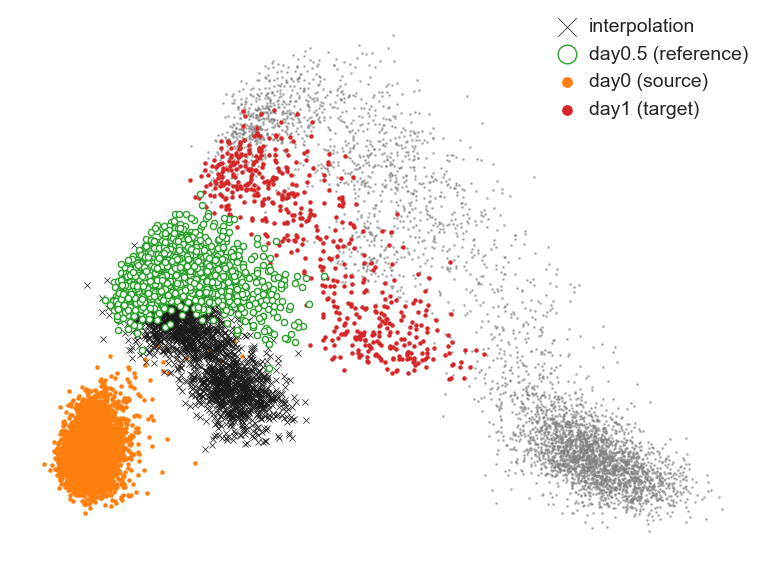

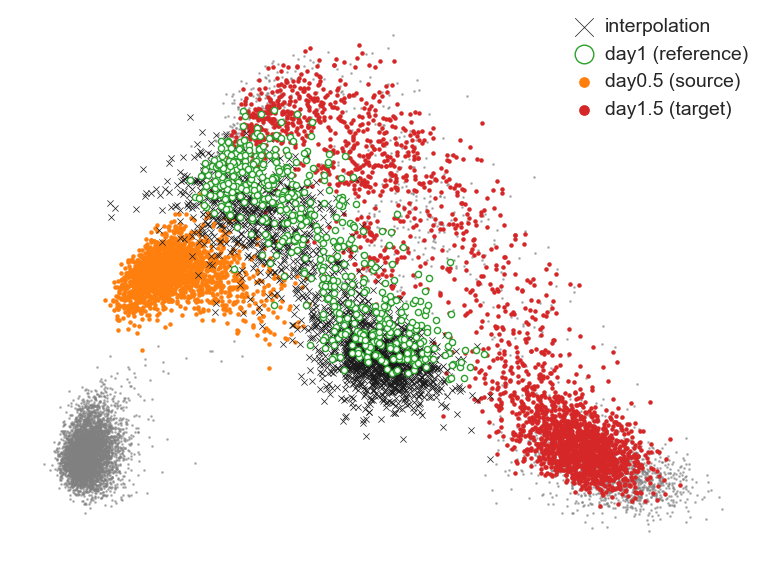

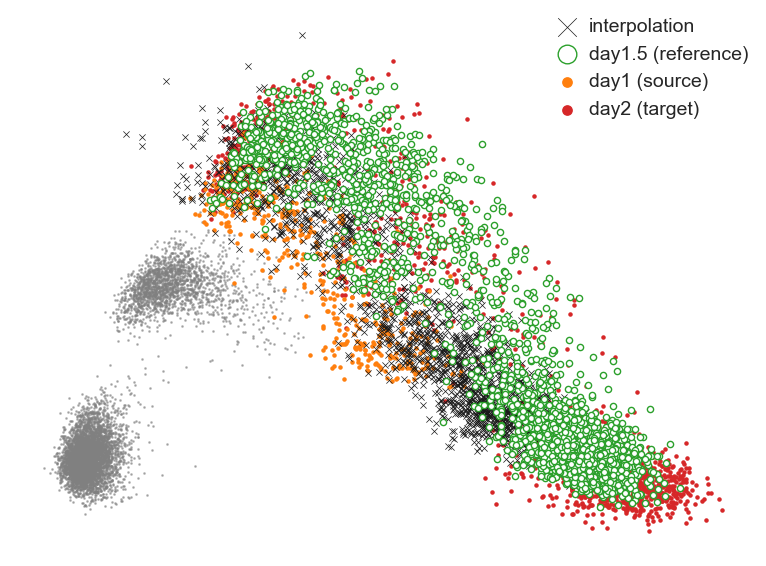

In [15]:
for s_, t_ in ((0, 2), (1, 3), (2, 4)):
    X_true = X[s_ + 1]
    X_interpolation = scegot.make_interpolation_data(
        gmm_models[s_],
        gmm_models[t_],
        0.5,
        columns=X[0].columns,
        seed=0,
    )
    X_source = X[s_]
    X_target = X[t_]
    alpha_true = 0.5

    df_concated = pd.concat([X_source, X_target, X_true, X_interpolation])
    x_range = (
        np.min(df_concated.iloc[:, 0]) - 5,
        np.max(df_concated.iloc[:, 0]) + 5,
    )
    y_range = (
        np.min(df_concated.iloc[:, 1]) - 5,
        np.max(df_concated.iloc[:, 1]) + 5,
    )
    x_col_name = X_true.columns[0]
    y_col_name = X_true.columns[1]

    fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)
    data_pca = pd.concat(X).values[:, :2]
    ax.scatter(data_pca[:, 0], data_pca[:, 1], color="gray", s=1, alpha=0.5, zorder=0)

    ax.scatter(
        X_interpolation[x_col_name].values,
        X_interpolation[y_col_name].values,
        marker="x",
        color="k",
        label="interpolation",
        # alpha=alpha_interpolation,
        alpha=1,
        zorder=20,
        s=20,
        linewidth=0.5,
    )
    ax.scatter(
        X_true[x_col_name].values,
        X_true[y_col_name].values,
        marker="o",
        facecolor="w",
        edgecolors=matplotlib.cm.tab10(2),
        # color=matplotlib.cm.tab10(2),
        label=f"{scegot.day_names[s_+1]} (reference)",
        alpha=1,
        zorder=20,
        s=20,
    )
    if X_source is not None:
        ax.scatter(
            X_source[x_col_name].values,
            X_source[y_col_name].values,
            marker="o",
            color=matplotlib.cm.tab10(1),  # "lightblue",
            label=f"{scegot.day_names[s_]} (source)",
            alpha=1,
            zorder=1,
            s=5,
        )
    if X_target is not None:
        ax.scatter(
            X_target[x_col_name].values,
            X_target[y_col_name].values,
            marker="o",
            color=matplotlib.cm.tab10(3),  # "lightgreen",
            label=f"{scegot.day_names[t_]} (target)",
            alpha=1,
            zorder=0,
            s=5,
        )
    leg = ax.legend(
        fontsize=14,
        markerscale=3,
        borderaxespad=0,
        frameon=False,
        handletextpad=0.1,
        facecolor="w",
    )
    for lh in leg.legend_handles:
        lh.set_alpha(1)
    ax.axis("off")
    fig.savefig(
        f"../figure/Fig_Intp_PCA_{scegot.day_names[s_+1]}.jpeg",
        format="jpeg", 
        dpi=300, 
        bbox_inches="tight"
    )

## Box plot

100/100

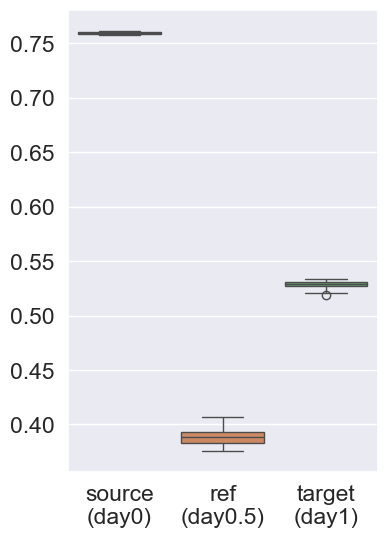

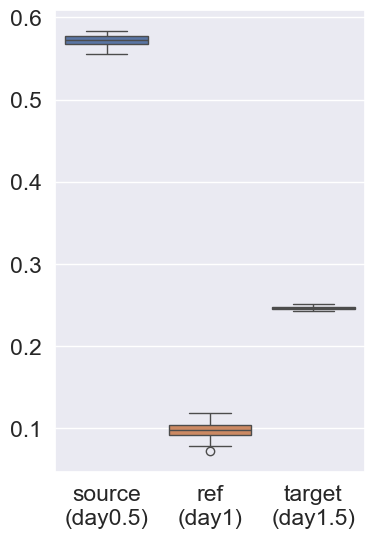

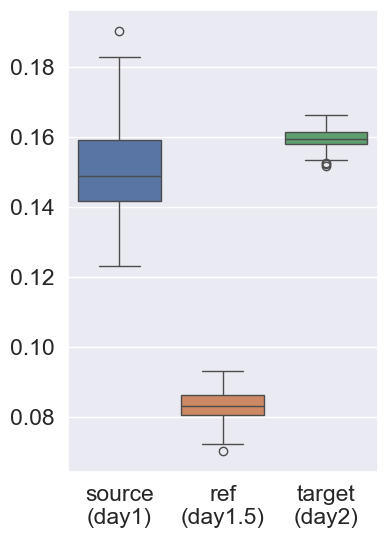

In [14]:
for s_, t_ in ((0, 2), (1, 3), (2, 4)):
    n_sc_ = 100
    n_samples = 1000

    silhouette_scores_ref = np.empty(n_sc_)
    silhouette_scores_src = np.empty(n_sc_)
    silhouette_scores_trg = np.empty(n_sc_)

    X_true_ = X[s_ + 1]
    for i in range(n_sc_):
        print("\r%d/%d" % (i + 1, n_sc_), end="")
        df_interpolation = scegot.make_interpolation_data(
            gmm_models[s_],
            gmm_models[t_],
            0.5,
            X[0].columns,
            n_samples=n_samples,
            seed=i,
        )
        X_ss_ = pd.concat([df_interpolation, X_true_]).values[:, :2]
        labels_ss_ = np.empty(X_ss_.shape[0], dtype=object)
        labels_ss_[: len(df_interpolation)] = "Interpolation"
        labels_ss_[len(df_interpolation) :] = "Reference"
        silhouette_scores_ref[i] = sklearn.metrics.silhouette_score(X_ss_, labels_ss_)

        X_ss_ = pd.concat([df_interpolation, X[s_]]).values[:, :2]
        labels_ss_ = np.empty(X_ss_.shape[0], dtype=object)
        labels_ss_[: len(df_interpolation)] = "Interpolation"
        labels_ss_[len(df_interpolation) :] = "Reference"
        silhouette_scores_src[i] = sklearn.metrics.silhouette_score(X_ss_, labels_ss_)

        X_ss_ = pd.concat([df_interpolation, X[t_]]).values[:, :2]
        labels_ss_ = np.empty(X_ss_.shape[0], dtype=object)
        labels_ss_[: len(df_interpolation)] = "Interpolation"
        labels_ss_[len(df_interpolation) :] = "Reference"
        silhouette_scores_trg[i] = sklearn.metrics.silhouette_score(X_ss_, labels_ss_)

    sns.set(font_scale=1.5)
    fig, ax = plt.subplots(figsize=(4, 6), facecolor="w")
    df_ss_ = pd.DataFrame(
        {
            f"source\n({scegot.day_names[s_]})": silhouette_scores_src,
            f"ref\n({scegot.day_names[s_+1]})": silhouette_scores_ref,
            f"target\n({scegot.day_names[t_]})": silhouette_scores_trg,
        }
    )
    sns.boxplot(df_ss_, ax=ax)
    fig.savefig(
        f"../figure/Fig_Intp_Silhouette_{scegot.day_names[s_+1]}.jpeg", 
        format="jpeg", 
        dpi=300, 
        bbox_inches="tight"
    )